In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ACOLLINEARITY FUNCTION
def angleacoll(th1,th2,ph1,ph2):
    v1=[np.sin(th1)*np.cos(ph1),np.sin(th1)*np.sin(ph1),np.cos(th1)]
    v2=[np.sin(th2)*np.cos(ph2),np.sin(th2)*np.sin(ph2),np.cos(th2)]
    dot = np.dot(v1,v2)
    return (abs(np.pi-np.arccos(dot)))

#function that finds number of events in dataframe
#it identifies an events by pair event number and run number
def n_events(df):
    sumev = 0
    for item in df.groupby(['ievt', 'irun']).size():
        sumev = sumev + item
    return sumev

#find corresponding cross section given the channel
def dfxsec(dfname, df_names):
    index = df_names.index(dfname)
    return xsections[index]

#find scale factor by which each channel needs to be multiplied to match data
def scalefactor(lumi, n_events, xsec):
    return (xsec*lumi)/n_events


def LogLR(expBkg, expSig, obs):
    #avoid log of 0 using super small number #hack
    result = obs*np.log(max(expSig+expBkg, 0.000001)) - expSig - obs*np.log(max(expBkg,0.000001))
    return -2*result

In [3]:
#initial definitions


backgrounds = ['eeqq','qq','wen','ww','zee','zz']
backgrounds_cs = [15600,102,2.90,16.5,3.35,0.975] #pb
signals = ['higgs_85','higgs_90','higgs_95']
signal_cs = [0.0940,0.0667,0.0333] #pb
data = ['data']



#concatenate all the channels
channels = backgrounds + signals + data
xsections = backgrounds_cs + signal_cs

#list which takes into account whether the channel is a background (bkg), signal (sgn), or data (data)
bkgsigdata = []

#dataframes lists
df_names = [] #need to work with names instead of just df because python cannot find a dataframe in a list of dataframes, so i just search by name
df_list = []
df_list_cut = []

#factor *signal to make it more visible (accounted for in efficiencies)
pumpsignal = 100    

#integrate luminosity
int_lumi = 176.773 #pb^-1

In [4]:
################################
# creation of all df and lists #
################################


for channel in channels:
    #fill the dataframes
    filename = './l3higgs189/higgs_' + channel + '.csv'
    dfname = 'df_' + channel
    vars()[dfname] = pd.read_csv(filename)
       
    #add xmj1+xmj2 column (probably will need it for a cut)
    (vars()[dfname])['xmj1p2'] = (vars()[dfname])['xmj1']+(vars()[dfname])['xmj2']
    
    #add reconstructed higgs mass after scaling the missing mass to the Z mass
    #TODO: FIX THIS PROBLEM
    scalemissing = (vars()[dfname])['mmis']/91.2
    (vars()[dfname])['mrechiggs'] = ((vars()[dfname])['xmj1']+(vars()[dfname])['xmj2'])*scalemissing
    
    #add recoiling mass against jets
    angle = 90
    recmass = []
    acollin = []
    for index, row in (vars()[dfname]).iterrows():
        #recoil mass
        recoilmass=0
        theta_jets = (row['xmj1']*row['thj1']+row['xmj2']*row['thj2'])/(row['xmj1']+row['xmj2'])
        phi_jets = (row['xmj1']*row['phj1']+row['xmj2']*row['phj2'])/(row['xmj1']+row['xmj2'])
        if ((row['ele_phi'] < phi_jets+180+angle) and (row['ele_phi'] > phi_jets+180-angle) and (row['ele_the'] < theta_jets+180+angle) and (row['ele_the'] > theta_jets+180-angle)):
            recoilmass += 0.000511*row['ele_num']
        if ((row['muon_phi'] < phi_jets+180+angle) and (row['muon_phi'] > phi_jets+180-angle) and (row['muon_the'] < theta_jets+180+angle) and (row['muon_the'] > theta_jets+180-angle)):
            recoilmass += 0.105*row['muon_num']
        recmass.append(recoilmass)
        #acollinearity
        acollin.append(angleacoll(row['thj1'],row['thj2'],row['phj1'],row['phj2']))
            
    (vars()[dfname])['rec_mass'] = recmass
    (vars()[dfname])['acoll'] = acollin
        
    
    
    #fill the bkgsigdata list, categorizing bkg, sgn, data
    if channel in backgrounds:
        bkgsigdata.append('bkg')
    elif channel in signals:
        bkgsigdata.append('sgn')
    elif channel in data:
        bkgsigdata.append('data')
        
    #fill dataframes lists
    df_names.append(dfname)
    df_list.append(vars()[dfname])
    

In [5]:
df_qq

,irun,ievt,ifi,idp1,idp2,encm,btag1,btag2,ucsdbt0,mvis,...,ele_the,ele_phi,muon_num,muon_ene,muon_the,muon_phi,xmj1p2,mrechiggs,rec_mass,acoll
0,715811,7511,100,0,0,188.699,0.070878,0.088318,0.074094,99.5288,...,0.00000,0.000000,0,-1.00000,0.000000,0.00000,63.57310,49.715419,0,0.985943
1,715901,7589,100,0,0,188.699,0.096775,0.016450,0.194146,101.3610,...,0.00000,0.000000,1,2.62451,1.975180,3.96581,27.04531,25.646812,0,0.045456
2,715902,7637,400,0,0,188.699,0.293025,0.181917,1.273600,69.2377,...,0.00000,0.000000,0,-1.00000,0.000000,0.00000,31.45860,39.737179,0,0.588289
3,715902,7650,300,0,0,188.699,0.396144,0.212295,2.132390,92.5908,...,0.00000,0.000000,0,-1.00000,0.000000,0.00000,45.25660,47.495710,0,0.154099
4,715904,7751,500,0,0,188.699,0.431277,0.128048,0.634858,90.1796,...,0.00000,0.000000,0,-1.00000,0.000000,0.00000,33.51510,36.100908,0,0.121798
5,715904,7754,500,0,0,188.699,0.377299,0.929129,2.515960,90.2634,...,0.00000,0.000000,0,-1.00000,0.000000,0.00000,26.31390,28.273882,0,0.047627
6,715905,7808,100,0,0,188.699,0.088202,0.023642,0.221303,87.6167,...,0.00000,0.000000,0,-1.00000,0.000000,0.00000,52.11433,54.916047,0,0.411876
7,715905,7848,500,0,0,188.699,0.192620,0.325205,0.648606,63.0631,...,0.00000,0.000000,1,14.75000,1.162810,5.14384,19.33328,23.976235,0,0.893012
8,715906,7864,200,0,0,188.699,0.008728,0.062145,0.160919,105.4640,...,0.00000,0.000000,0,-1.00000,0.000000,0.00000,21.20871,17.060686,0,0.543282
9,715906,7865,500,0,0,188.699,0.085526,0.634153,1.354100,72.2340,...,1.29939,3.242780,0,-1.00000,0.000000,0.00000,20.49606,25.493548,0,0.466047


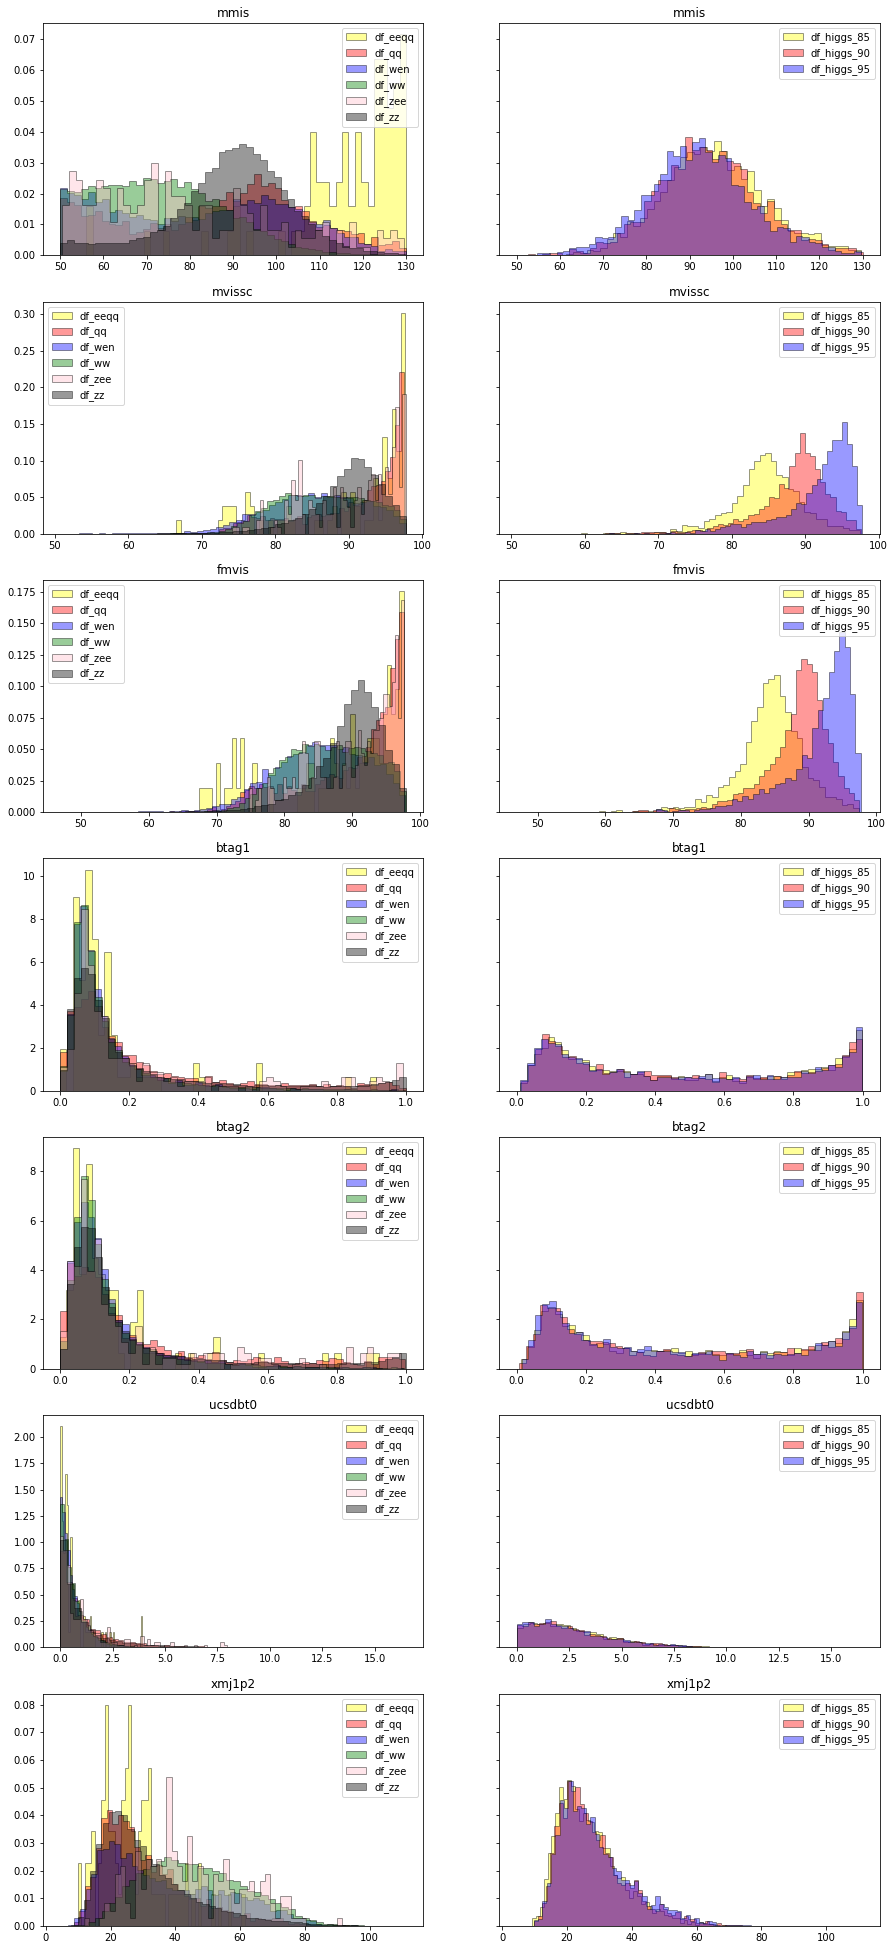

In [6]:
##########################################################
# plot all variables for signal and background (no cuts) #
##########################################################

#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['mmis', 'mvissc', 'fmvis', 'btag1', 'btag2', 'ucsdbt0','xmj1p2' ]
#varlist = ['mmis', 'pho_ene']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)

f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

for varname in varlist:
    index_var = varlist.index(varname)
    for dfname in df_names:
        index = df_names.index(dfname)
        
        #backgrounds
        if bkgsigdata[index] == 'bkg':
            #plot histograms (normalised area to 1)
            axs[index_var,0].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)
            
            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list[index]), n_events(df_list[index])))
            #axs[index_var,0].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
        
        #signals
        if bkgsigdata[index] == 'sgn':
            #plot histograms (normalised area to 1)
            axs[index_var,1].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)

            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list[index]), n_events(df_list[index])))
            #axs[index_var,1].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
    
    #plot title and legend for background (left) and signal (right)
    axs[index_var,0].set_title(varname)
    axs[index_var,0].legend(loc='best')
    axs[index_var,1].set_title(varname)
    axs[index_var,1].legend(loc='best')

#plt.show()

0.0
5.0


/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0


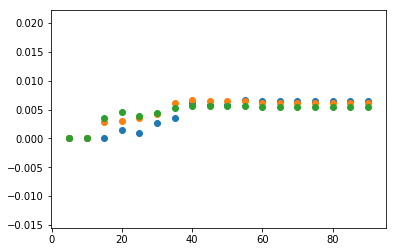

In [8]:
##########################################
# plot efficiency s/sqrt(b) varying cuts #
##########################################


#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'xmj1p2', 'ucsdbt0', 'mmis','acoll']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []

eff_85 = []
eff_90 = []
eff_95 = []


#btag
xrange_btag = np.linspace(0,1,21)
#angle
xrange_angle = np.linspace(0,90,19)
#ucsdbt0
xrange_bts = np.linspace(0,14,30)
#xmj1p2
xrange_xmj = np.linspace(10,100,10)


xrange = xrange_angle

for anglesaxon in xrange:
    df_list_cut = []
    print(anglesaxon)
    #f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

    for dfname in df_names:
        index = df_names.index(dfname)
        tmpdf = (df_list[index])[(df_list[index])['btag1'] > 0.8]
        tmpdf = tmpdf[tmpdf['btag2'] > 0.8]
        tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
        tmpdf = tmpdf[tmpdf['xmj1p2'] >40]
        tmpdf = tmpdf[tmpdf['acoll'] < anglesaxon*np.pi/180]
        df_list_cut.append(tmpdf)


    nevents = [0]*len(df_list)


    for varname in varlist:
        index_var = varlist.index(varname)
        for dfname in df_names:
            index = df_names.index(dfname)

            #backgrounds
            if bkgsigdata[index] == 'bkg':
                #plot histograms (normalised area to 1)
                #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                if(n_events(df_list_cut[index]) != 0):
                    #calculate scale factor (xs) and plot histograms
                    scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                    weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                    #axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                    nevents[index]=((n_events(df_list_cut[index]))*scalef)
                else: 
                    nevents[index]=0

            #signals
            if bkgsigdata[index] == 'sgn':
                #plot histograms (normalised area to 1)
                #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

                #calculate scale factor (xs) and plot histograms
                if(n_events(df_list_cut[index]) != 0):
                    scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                    weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                    #axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                    nevents[index]=((n_events(df_list_cut[index]))*scalef)
                else: 
                    nevents[index] = 0
        #plot title and legend for background (left) and signal (right)
        #axs[index_var,0].set_title(varname)
        #axs[index_var,0].legend(loc='best')
        #axs[index_var,1].set_title(varname)
        #axs[index_var,1].legend(loc='best')

    plt.show()


    bkg_ev = 0
    sgn_ev_85 = 0
    sgn_ev_90 = 0
    sgn_ev_95 = 0

    for nev in nevents:
        index = nevents.index(nev)
        if bkgsigdata[index] == 'bkg':
            bkg_ev+=nev
        elif bkgsigdata[index] == 'sgn':
            if index == 6:
                sgn_ev_85+=nev/pumpsignal
            elif index == 7:
                sgn_ev_90+=nev/pumpsignal
            elif index == 8:
                sgn_ev_95+=nev/pumpsignal

    eff_85.append(sgn_ev_85/np.sqrt(bkg_ev))
    eff_90.append(sgn_ev_90/np.sqrt(bkg_ev))
    eff_95.append(sgn_ev_95/np.sqrt(bkg_ev))

    
    
plt.scatter(xrange,eff_85)
plt.scatter(xrange,eff_90)
plt.scatter(xrange,eff_95)

plt.show()


In [ ]:
###################################
# output best cuts and efficiency #
###################################


# VERY VERY VERY VERY VERY MUCHER SLOWEST

'''import time

#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'xmj1p2', 'ucsdbt0', 'mmis','acoll']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []

eff_85 = []
eff_90 = []
eff_95 = []


#btag
xrange_btag = np.linspace(0,1,21)
#angle
xrange_angle = np.linspace(0,90,19)
#ucsdbt0
xrange_bts = np.linspace(0,14,30)
#xmj1p2
xrange_xmj = np.linspace(10,100,10)


'''#btag
xrange_btag = np.linspace(0,1,5)
#angle
xrange_angle = np.linspace(0,90,5)
#ucsdbt0
xrange_bts = np.linspace(0,14,5)
#xmj1p2
xrange_xmj = np.linspace(10,100,5)'''


maxeff85 = -1
bestcuts85 = []
maxeff90 = -1
bestcuts90 = []
maxeff95 = -1
bestcuts95 = []

start = time.time()

for anglesaxon in xrange_angle:
    print(anglesaxon)
    for btagg in xrange_btag:
        for ucsdbt00 in xrange_bts:
            for xmjj in xrange_xmj:
                df_list_cut = []
                #f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

                for dfname in df_names:
                    index = df_names.index(dfname)
                    tmpdf = (df_list[index])[(df_list[index])['btag1'] > btagg]
                    tmpdf = tmpdf[tmpdf['btag2'] > btagg]
                    tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
                    tmpdf = tmpdf[tmpdf['xmj1p2'] >40]
                    tmpdf = tmpdf[tmpdf['acoll'] < anglesaxon*np.pi/180]
                    df_list_cut.append(tmpdf)


                pumpsignal = 100    
                nevents = [0]*len(df_list)


                for varname in varlist:
                    index_var = varlist.index(varname)
                    for dfname in df_names:
                        index = df_names.index(dfname)

                        #backgrounds
                        if bkgsigdata[index] == 'bkg':
                            #plot histograms (normalised area to 1)
                            #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                            if(n_events(df_list_cut[index]) != 0):
                                #calculate scale factor (xs) and plot histograms
                                scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                                #axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                                nevents[index]=((n_events(df_list_cut[index]))*scalef)
                            else: 
                                nevents[index]=0

                        #signals
                        if bkgsigdata[index] == 'sgn':
                            #plot histograms (normalised area to 1)
                            #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

                            #calculate scale factor (xs) and plot histograms
                            if(n_events(df_list_cut[index]) != 0):
                                scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                                #axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                                nevents[index]=((n_events(df_list_cut[index]))*scalef)
                            else: 
                                nevents[index] = 0
                    #plot title and legend for background (left) and signal (right)
                    #axs[index_var,0].set_title(varname)
                    #axs[index_var,0].legend(loc='best')
                    #axs[index_var,1].set_title(varname)
                    #axs[index_var,1].legend(loc='best')

                #plt.show()


                bkg_ev = 0
                sgn_ev_85 = 0
                sgn_ev_90 = 0
                sgn_ev_95 = 0

                for nev in nevents:
                    index = nevents.index(nev)
                    if bkgsigdata[index] == 'bkg':
                        bkg_ev+=nev
                    elif bkgsigdata[index] == 'sgn':
                        if index == 6:
                            sgn_ev_85+=nev/pumpsignal
                        elif index == 7:
                            sgn_ev_90+=nev/pumpsignal
                        elif index == 8:
                            sgn_ev_95+=nev/pumpsignal



                tmp_maxeff85 = (sgn_ev_85/np.sqrt(bkg_ev))
                tmp_maxeff90 = (sgn_ev_90/np.sqrt(bkg_ev))
                tmp_maxeff95 = (sgn_ev_95/np.sqrt(bkg_ev))

                if (sgn_ev_85/np.sqrt(bkg_ev) > maxeff85):
                    maxeff85 = sgn_ev_85/np.sqrt(bkg_ev)
                    bestcuts85 = []
                    bestcuts85.append(btagg)
                    bestcuts85.append(anglesaxon)
                    bestcuts85.append(ucsdbt00)
                    bestcuts85.append(xmjj)


                if (sgn_ev_90/np.sqrt(bkg_ev) > maxeff90):
                    maxeff90 = sgn_ev_90/np.sqrt(bkg_ev)
                    bestcuts90 = []
                    bestcuts90.append(btagg)
                    bestcuts90.append(anglesaxon)
                    bestcuts90.append(ucsdbt00)
                    bestcuts90.append(xmjj)


                if (sgn_ev_95/np.sqrt(bkg_ev) > maxeff95):
                    maxeff95 = sgn_ev_95/np.sqrt(bkg_ev)
                    bestcuts95 = []
                    bestcuts95.append(btagg)
                    bestcuts95.append(anglesaxon)
                    bestcuts95.append(ucsdbt00)
                    bestcuts95.append(xmjj)

            
print(maxeff85, bestcuts85)
print(maxeff90, bestcuts90)
print(maxeff95, bestcuts95)

stop = time.time()

print('time taken: ' + str(stop-start))'''


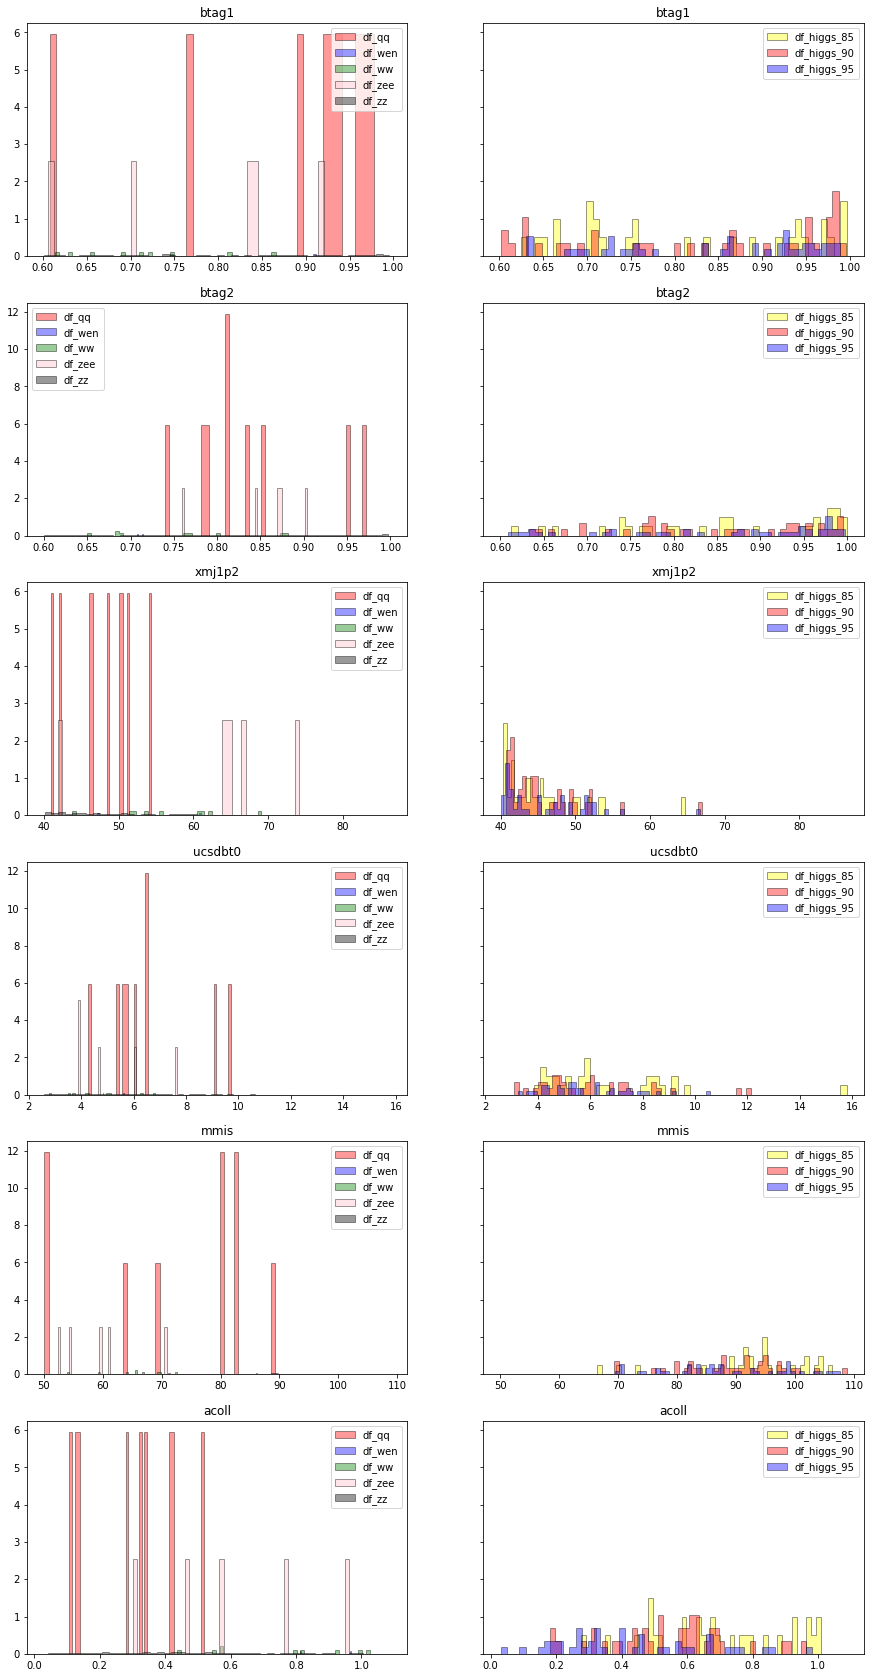

In [9]:
############################################################
# plot all variables for signal and background (WITH cuts) #
############################################################

#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'xmj1p2', 'ucsdbt0', 'mmis','acoll']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []


f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

for dfname in df_names:
    index = df_names.index(dfname)
    tmpdf = (df_list[index])[(df_list[index])['btag1'] > 0.6]
    tmpdf = tmpdf[tmpdf['btag2'] > 0.6]
    tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
    tmpdf = tmpdf[tmpdf['xmj1p2'] >40]
    tmpdf = tmpdf[tmpdf['acoll'] < 65*np.pi/180]
    df_list_cut.append(tmpdf)


pumpsignal = 100    
nevents = [0]*len(df_list)


for varname in varlist:
    index_var = varlist.index(varname)
    for dfname in df_names:
        index = df_names.index(dfname)

        #backgrounds
        if bkgsigdata[index] == 'bkg':
            #plot histograms (normalised area to 1)
            #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
            if(n_events(df_list_cut[index]) != 0):
                #calculate scale factor (xs) and plot histograms
                scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                nevents[index]=((n_events(df_list_cut[index]))*scalef)
            else: 
                nevents[index]=0

        #signals
        if bkgsigdata[index] == 'sgn':
            #plot histograms (normalised area to 1)
            #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

            #calculate scale factor (xs) and plot histograms
            if(n_events(df_list_cut[index]) != 0):
                scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                nevents[index]=((n_events(df_list_cut[index]))*scalef)
            else: 
                nevents[index] = 0
    #plot title and legend for background (left) and signal (right)
    axs[index_var,0].set_title(varname)
    axs[index_var,0].legend(loc='best')
    axs[index_var,1].set_title(varname)
    axs[index_var,1].legend(loc='best')


plt.show()


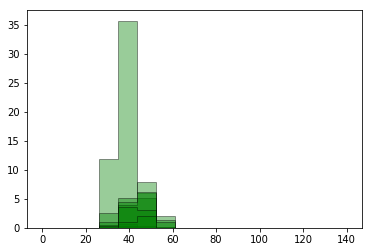

In [37]:
#######################
# log likelihood ploz #
#######################
   
df_list_cut = []

for dfname in df_names:
    index = df_names.index(dfname)
    tmpdf = (df_list[index])[(df_list[index])['btag1'] > 0.6]
    tmpdf = tmpdf[tmpdf['btag2'] > 0.6]
    tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
    tmpdf = tmpdf[tmpdf['xmj1p2'] >40]
    tmpdf = tmpdf[tmpdf['acoll'] < 65*np.pi/180]
    df_list_cut.append(tmpdf)

bins = np.linspace(0,140,17)


signal85_mh = []
signal90_mh = []
signal95_mh = []
backgr_mh = [0]*(len(bins)-1)
data_mh = []



pumpsignal = 100    
nevents = [0]*len(df_list)


for dfname in df_names:
    index = df_names.index(dfname)
    
    #data
    if bkgsigdata[index] == 'data':
        data_histo,bins_data,patches_data = plt.hist(((df_list_cut[index])['mrechiggs']), bins=bins, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
    

    #signals
    #signal with mh=85 GeV
    if index == 6:
        scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
        sgn_85,bins_sgn_85,patches_sgn_85 = plt.hist(((df_list_cut[index])['mrechiggs']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

    #signal with mh=90 GeV
    if index == 7:
        scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
        sgn_90,bins_sgn_90,patches_sgn_90 = plt.hist(((df_list_cut[index])['mrechiggs']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

    #signal with mh=95 GeV
    if index == 8:
        scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
        sgn_95,bins_sgn_95,patches_sgn_95 = plt.hist(((df_list_cut[index])['mrechiggs']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)


    #backgrounds
    #SUM OVER
    if bkgsigdata[index] == 'bkg':
        if(n_events(df_list_cut[index]) != 0):
            #calculate scale factor (xs) 
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
            bkg,bins_bkg,patches_bkg = plt.hist(((df_list_cut[index])['mrechiggs']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
            backgr_mh = np.add(backgr_mh,bkg)
            

#calculate -2lnq
#backgr_mh
#sgn_
#data_histo

    


    
    




In [32]:
bins_bkg

array([26.29253122, 33.70431925, 41.11610728, 48.52789531, 55.93968334,
       63.35147137])

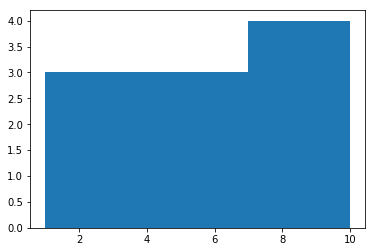

In [10]:
a = [1,2,3,4,5,6,7,8,9,10]
n, bins, patches = plt.hist(a,bins=3)

In [13]:
#df_eeqq['mrechiggs']
(df_list_cut[0])['mrechiggs']

Series([], Name: mrechiggs, dtype: float64)

In [22]:
a = [1,2,3]

In [23]:
if a:
    print ('yo')

yo


In [35]:
bins = np.linspace(0,140,17)
print(bins)
print(len(bins))

[  0.     8.75  17.5   26.25  35.    43.75  52.5   61.25  70.    78.75
  87.5   96.25 105.   113.75 122.5  131.25 140.  ]
17
